In [1]:
import torch
import torchvision.datasets as dsets
from torch.autograd import Variable
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torch.nn.functional as F
import numpy as np

In [2]:
# Change working directory
import os
os.chdir('/content/drive/My Drive/UOttawa/2020Fall/CSI5138/assignment2')

In [3]:
# Define the logistic regression
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)


    def forward(self, x):
        outputs = self.linear(x)
        return outputs

In [4]:
# Define a 3 layer MLP 28*28 -> 512 -> 128 -> 10
class MLP(torch.nn.Module):
  def __init__(self, input_dim, output_dim):
    super(MLP, self).__init__()
    self.input_dim = input_dim
    self.fc1 = torch.nn.Linear(input_dim, 512)
    self.fc2 = torch.nn.Linear(512, 128)
    self.fc3 = torch.nn.Linear(128, output_dim)
  
  
  def forward(self, x):
    x = x.view(-1, self.input_dim)
    output = F.relu(self.fc1(x))
    output = F.relu(self.fc2(output))
    return F.softmax(self.fc3(output))

print(MLP(784, 10))

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [5]:
class Net(torch.nn.Module):
  def __init__(self, dataset='mnist'):
    super(Net, self).__init__()
    self.dataset = dataset
    if dataset=='mnist':
      self.conv1 = torch.nn.Conv2d(1, 10, 5)
      self.fc1 = torch.nn.Linear(320, 50)
    else: 
      self.conv1 = torch.nn.Conv2d(3, 10, 5)
      self.fc1 = torch.nn.Linear(500, 50)
    self.conv2 = torch.nn.Conv2d(10, 20, 5)

    
    self.fc2 = torch.nn.Linear(50, 10)
  

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    if self.dataset=='mnist':
      x = x.view(-1, 320)
    else:
      x = x.view(-1, 500)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.softmax(x)

print(Net())

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [8]:
class play:
  def __init__(self, dataset, method):
    self.method = method
    self.batch_size = 100
    self.dataset = dataset
    if dataset == 'mnist':
      self.load_data_mnist()
    else:
      self.load_data_cifar()
    self.define_constants(method)


  def load_data_mnist(self):
    # Each image is 28*28, the training set contains 60000 examples, and the test set 10000 examples.
    self.train_dataset = dsets.MNIST(root='./MNIST', train=True, transform=transforms.ToTensor(), download=True)
    self.test_dataset = dsets.MNIST(root='./MNIST', train=False, transform=transforms.ToTensor())
    self.train_loader = torch.utils.data.DataLoader(dataset=self.train_dataset, batch_size=self.batch_size, shuffle=True)
    self.test_loader = torch.utils.data.DataLoader(dataset=self.test_dataset, batch_size=self.batch_size, shuffle=False)
  

  def load_data_cifar(self):
    self.train_dataset = torchvision.datasets.CIFAR10(root='./cifar', train=True, transform=transforms.ToTensor(), download=True)
    self.test_dataset = torchvision.datasets.CIFAR10(root='./cifar', train=False, transform=transforms.ToTensor(), download=True)
    self.train_loader = torch.utils.data.DataLoader(dataset=self.train_dataset, batch_size=self.batch_size, shuffle=True)
    self.test_loader = torch.utils.data.DataLoader(dataset=self.test_dataset, batch_size=self.batch_size, shuffle=False)


  
  def imshow(self):
    # get some random training images
    dataiter = iter(self.train_loader)
    images, labels = dataiter.next()

    img = torchvision.utils.make_grid(images) / 2 + 0.5     # unnormalize
    print(type(img))
    print(img.shape)
    img = img[0:4]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    # print labels
    print(' '.join('%5s' % labels[j].item() for j in range(4)))


  def define_constants(self, method):
    #Define constants
    if self.dataset == 'mnist':
      self.input_dim = 784
    else: self.input_dim = 3072

    self.output_dim = 10
    if method == 'lr':
      self.n_iters = 3000
      self.epochs = 5
      lr_rate = 0.001
      self.model = LogisticRegression(self.input_dim, self.output_dim).cuda()
    elif method == 'mlp':
      self.n_iters = 3000
      self.epochs = 8
      lr_rate = 0.1
      self.model = MLP(self.input_dim, self.output_dim).cuda()
    elif method == 'cnn':
      self.n_iters = 3000
      self.epochs = 10
      lr_rate = 0.1
      self.model = Net(self.method).cuda()
    self.criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
    self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr_rate)

  
  def train(self):
    iter = 0
    l = []
    a = []
    for epoch in range(int(self.epochs)):
        l_temp = []
        for i, (images, labels) in enumerate(self.train_loader):
            if not self.method == 'cnn':
              images = Variable(images.view(-1, self.input_dim))
            images = images.cuda()
            labels = Variable(labels).cuda()

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            l_temp.append(loss.item())

            iter+=1
            if iter%100==0:
                # calculate Accuracy
                correct = 0
                total = 0
                for images, labels in self.test_loader:
                    if not self.method == 'cnn':
                      images = Variable(images.view(-1, self.input_dim))
                    images = images.cuda()
                    outputs = self.model(images).cuda()
                    _, predicted = torch.max(outputs.data, 1)
                    total+= labels.size(0)
                    # for gpu, bring the predicted and labels back to cpu fro python operations to work
                    correct+= (predicted == labels).sum()
                accuracy = 100 * correct//total
                a.append(accuracy.item())
                print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))
        l.append(sum(l_temp)/len(l_temp))
    fig, ax = plt.subplots()
    sns.lineplot(x=range(len(l)), y=l, color='blue', label = 'Loss', ax=ax)
    plt.title("Loss of {}".format(self.method))
    plt.xlabel("iterate")
    plt.ylabel("Loss")  
        
    fig, ax = plt.subplots()
    sns.lineplot(x=range(len(a)), y=a, color='blue', label = 'Accuracy', ax=ax)
    plt.title("Accuracy of {}".format(self.method))
    plt.xlabel("iteration(*100)")
    plt.ylabel("Accuracy")
  

  

In [9]:
mn = play(dataset='cifar', method='cnn')
mn.train()

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


RuntimeError: ignored

In [13]:
mn = play(dataset='cifar', method='lr')
mn.train()

Files already downloaded and verified
Files already downloaded and verified


RuntimeError: ignored

In [ ]:
mn1 = mnist('lr')
mn1.train()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Iteration: 100. Loss: 2.3003227710723877. Accuracy: 14.
Iteration: 200. Loss: 2.2981252670288086. Accuracy: 15.
Iteration: 300. Loss: 2.2842442989349365. Accuracy: 26.
Iteration: 400. Loss: 1.902312159538269. Accuracy: 54.
Iteration: 500. Loss: 1.804226279258728. Accuracy: 70.
Iteration: 600. Loss: 1.76531183719635. Accuracy: 69.
Iteration: 700. Loss: 1.7190874814987183. Accuracy: 72.
Iteration: 800. Loss: 1.7514549493789673. Accuracy: 74.
Iteration: 900. Loss: 1.7567152976989746. Accuracy: 75.
Iteration: 1000. Loss: 1.692921757698059. Accuracy: 75.
Iteration: 1100. Loss: 1.6903187036514282. Accuracy: 75.
Iteration: 1200. Loss: 1.6789740324020386. Accuracy: 76.
Iteration: 1300. Loss: 1.6636067628860474. Accuracy: 76.
Iteration: 1400. Loss: 1.6961828470230103. Accuracy: 76.
Iteration: 1500. Loss: 1.622135877609253. Accuracy: 76.
Iteration: 1600. Loss: 1.7067257165908813. Accuracy: 77.
Iteration: 1700. Loss: 1.6229948997497559. Accuracy: 77.
Iteration: 1800. Loss: 1.639493465423584. Accu

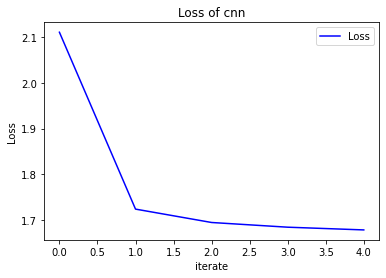

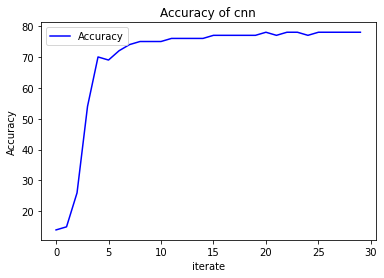

In [9]:
mn2 = mnist('cnn')
mn2.train()